In [87]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.metrics import mean_squared_error

In [2]:
data_file = pd.read_csv('MOVIES_WITHOUT_PTT_TIME_ASC.csv', encoding='cp950')
test_file = pd.read_csv('Testing.csv')
data_length = len(data_file)
test_length = len(test_file)

In [3]:
country = []
genre = []
date = []
test_country = []
test_genre = []
test_date = []
for i in range(data_length):
    t_country = str(data_file['COUNTRY'][i]).split(',')
    t_genre = str(data_file['IMDB_GENRE'][i]).split(',')
    t_date = str(data_file['DATE_TW'][i]).split('/')
    t_date = [ int(d) for d in t_date]
    country.append(t_country)
    genre.append(t_genre)
    date.append(t_date)
for i in range(test_length):
    t_country = str(test_file['COUNTRY'][i]).split(',')
    t_genre = str(test_file['IMDB_GENRE'][i]).split(',')
    t_date = str(test_file['DATE_TW'][i]).split('/')
    t_date = [ int(d) for d in t_date]
    test_country.append(t_country)
    test_genre.append(t_genre)
    test_date.append(t_date)

In [4]:
mlb = MultiLabelBinarizer()
all_country = mlb.fit_transform(country + test_country)
all_genre = mlb.fit_transform(genre + test_genre)
country = all_country[:-20]
test_country = all_country[-20:]
genre = all_genre[:-20]
test_genre = all_genre[-20:]

In [5]:
date = np.array(date)
runtime = np.array(data_file['IMDB_RUNTIME']).reshape(data_length, 1)
dir_detail = np.array(data_file[['DIRECTOR_WINS', 'DIRECTOR_NOMINATIONS', 
                                 'DIRECTOR_RATINGS']])
star_detail = np.array(data_file[['STAR_1_WINS', 'STAR_1_NOMINATIONS', 
                                  'STAR_1_RATINGS', 'STAR_2_WINS', 
                                  'STAR_2_NOMINATIONS', 'STAR_2_RATINGS', 
                                  'STAR_3_WINS', 'STAR_3_NOMINATIONS', 
                                  'STAR_3_RATINGS']])
yahoo = np.array(data_file[['YAHOO_EVALUATION', 'YAHOO_VOTER']])
PTT = np.array(data_file[['PTT_ARTICLE', 'PTT_PUSH', 'PTT_ARROW', 
                          'PTT_PULL', 'PTT_REPLY']])
youtube = np.array(data_file[['YOUTUBE_VIEW', 'YOUTUBE_LIKE', 'YOUTUBE_DISLIKE']])

In [6]:
test_date = np.array(test_date)
test_runtime = np.array(test_file['IMDB_RUNTIME']).reshape(test_length, 1)
test_dir_detail = np.array(test_file[['DIRECTOR_WINS', 'DIRECTOR_NOMINATIONS', 
                                 'DIRECTOR_RATINGS']])
test_star_detail = np.array(test_file[['STAR_1_WINS', 'STAR_1_NOMINATIONS', 
                                  'STAR_1_RATINGS', 'STAR_2_WINS', 
                                  'STAR_2_NOMINATIONS', 'STAR_2_RATINGS', 
                                  'STAR_3_WINS', 'STAR_3_NOMINATIONS', 
                                  'STAR_3_RATINGS']])
test_yahoo = np.array(test_file[['YAHOO_EVALUATION', 'YAHOO_VOTER']])
test_PTT = np.array(test_file[['PTT_ARTICLE', 'PTT_PUSH', 'PTT_ARROW', 
                          'PTT_PULL', 'PTT_REPLY']])
test_youtube = np.array(test_file[['YOUTUBE_VIEW', 'YOUTUBE_LIKE', 'YOUTUBE_DISLIKE']])

In [164]:
x_train = np.concatenate((date, country, genre, runtime, dir_detail, star_detail,yahoo), axis=-1)
y_train = np.array(data_file['IMDB_RATING']).reshape(data_length, 1)

x_test = np.concatenate((test_date, test_country, test_genre, test_runtime, 
                         test_dir_detail, test_star_detail, test_yahoo), axis=-1)
y_test = np.array(test_file['IMDB_RATING']).reshape(test_length, 1)

In [165]:
mean = np.mean(x_train, axis=0)
sigma = np.std(x_train, axis=0)
x_train = (x_train-mean)/(sigma + 1e-20)
x_test = (x_test-mean)/(sigma + 1e-20)

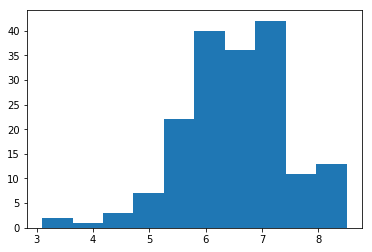

In [173]:
plt.hist(y_train)
plt.show()

In [166]:
x_valid = x_train[-20:]
y_valid = y_train[-20:]

x_train = x_train[:-20]
y_train = y_train[:-20]

In [167]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_train).clip(1,10)
y_pred_valid = lr.predict(x_valid).clip(1,10)
y_pred_test = lr.predict(x_test).clip(1,10)
print('R^2: ' + str(lr.score(x_train, y_train)))
print('train score: ' + str(np.sqrt(mean_squared_error(y_train, y_pred))))
print('valid score: ' + str(np.sqrt(mean_squared_error(y_valid, y_pred_valid))))
print('test score: ' + str(np.sqrt(mean_squared_error(y_test, y_pred_test))))

R^2: 0.737761709283
train score: 0.476841499974
valid score: 1.97780123855
test score: 2.24780782836


In [131]:
def create_regression_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(x_train.shape[1],), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.add(Lambda(lambda x: x + K.constant(6.5558, dtype=K.floatx())))
    return model

In [132]:
def rmse(y_true, y_pred):
    K.clip(y_pred, 1.0, 10.0)
    return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))

In [135]:
r_model = create_regression_model()
callbacks = []
callbacks.append(ModelCheckpoint('model.h5',
                                 monitor='val_loss', save_best_only=True, period=1))
callbacks.append(EarlyStopping(monitor='val_loss', patience=5))
r_model.compile(loss=rmse, optimizer='adam', metrics=[rmse])
r_model.fit(x_train, y_train, batch_size=5, validation_data=(x_valid, y_valid), 
          epochs=100, callbacks=callbacks)

r_model = load_model('model.h5', custom_objects={'rmse': rmse})
y_pred_test = r_model.predict(x_test).clip(1,10)
print('test score: ' + str(np.sqrt(mean_squared_error(y_test, y_pred_test))))

Train on 177 samples, validate on 20 samples
Epoch 1/100
177/177 [==============================] - 3s - loss: 1.2134 - rmse: 1.2134 - val_loss: 0.9952 - val_rmse: 0.9952
Epoch 2/100
177/177 [==============================] - 0s - loss: 1.0428 - rmse: 1.0428 - val_loss: 1.0091 - val_rmse: 1.0091
Epoch 3/100
177/177 [==============================] - 0s - loss: 0.9157 - rmse: 0.9157 - val_loss: 1.0070 - val_rmse: 1.0070
Epoch 4/100
177/177 [==============================] - 0s - loss: 0.9302 - rmse: 0.9302 - val_loss: 0.9951 - val_rmse: 0.9951
Epoch 5/100
177/177 [==============================] - 0s - loss: 0.8774 - rmse: 0.8774 - val_loss: 0.9987 - val_rmse: 0.9987
Epoch 6/100
177/177 [==============================] - 0s - loss: 0.9240 - rmse: 0.9240 - val_loss: 0.9589 - val_rmse: 0.9589
Epoch 7/100
177/177 [==============================] - 0s - loss: 0.8788 - rmse: 0.8788 - val_loss: 0.9445 - val_rmse: 0.9445
Epoch 8/100
177/177 [==============================] - 0s - loss: 0.8845 

In [74]:
c_y_train = []
for r in y_train:
    temp = 0
    if r >= 7:
        temp = 0
    elif r >= 6.2:
        temp = 1
    else:
        temp = 2
    c_y_train.append(temp)
c_y_train = np.array(c_y_train)

In [75]:
c_y_test = []
for r in y_test:
    temp = 0
    if r >= 7:
        temp = 0
    elif r >= 6.2:
        temp = 1
    else:
        temp = 2
    c_y_test.append(temp)
c_y_test = np.array(c_y_test)

In [76]:
c_x_valid = x_train[-20:]
c_y_valid = c_y_train[-20:]

c_x_train = x_train[:-20]
c_y_train = c_y_train[:-20]

In [77]:
clf = RandomForestClassifier(n_estimators=200, min_samples_leaf=5, max_depth=5, random_state=0)
clf.fit(c_x_train, c_y_train)
print('train score: ' + str(clf.score(c_x_train, c_y_train)))
print('valid score: ' + str(clf.score(c_x_valid, c_y_valid)))
print('test score: ' + str(clf.score(x_test, c_y_test)))

train score: 0.920903954802
valid score: 0.55
test score: 0.5
